In [5]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [6]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# # Hatakeyama 2003
# HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
# HK_2003_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json')
H_2005_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_smc_samples.json')
O_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss= load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json')
vK_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_smc_samples.json')
R_2015_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json')
K_2017_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
# HK_2003_log_magr = np.mean([chain[-1] for chain in HK_2003_ss['log_marginal_likelihood']])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
vK_2009_log_magr = np.mean([chain[-1] for chain in VK_2009_ss['log_marginal_likelihood'][0]]) 
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood'][0]])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood']])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])
H_2005_log_magr = np.mean([chain[-1] for chain in H_2005_ss['log_marginal_likelihood'][0]])

# Levchenko 2000 has 800 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
L_2000_posts = [L_2000_post for _ in range(10)]
L_2000_post = np.vstack(L_2000_posts)[rng.permutation(np.arange(4000))]

# Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
B_2007_posts = [B_2007_post for _ in range(10)]
B_2007_post = np.vstack(B_2007_posts)[rng.permutation(np.arange(4000))]

# Orton 2009 only has 1000 posterior predictive samples, so we duplicate and randomly permute them to get 4000
O_2009_posts = [O_2009_post for _ in range(10)]
O_2009_post = np.vstack(O_2009_posts)[rng.permutation(np.arange(4000))]

# vonKreigsheim 2009 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
vK_2009_posts = [vK_2009_post for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)[rng.permutation(np.arange(4000))]

# Hornberg 2005 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
H_2005_posts = [H_2005_post for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)[rng.permutation(np.arange(4000))]

# downsample Shin 2014
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
S_2014_post_downsample = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

colors = get_color_pallette()

Now we want to construct three MMI predictors:
1. All models
2. Exclude the worst model - *Hatakeyama 2003*
3. Exclude the best model - *Kochanczyk 2017*

In [7]:
# function to compute model probs
def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

def model_probs(log_marginal_likes):
    """Computes the model probabilities from a list of log marginal likelihoods."""

    n_models = len(log_marginal_likes)
    prior_prob = 1/n_models
    model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)
    

    return model_probs

In [8]:
# for all model case
# model_names_all = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
# display_names_all = ["K' 2000", "L' 2000", "H' 2003","H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
# log_marginal_likes_all = np.array([K_2000_log_magr, L_2000_log_magr, HK_2003_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
# dict_compare_all = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hatakeyama_2003': HK_2003_idata, 'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata,
# 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}
model_names_all = ['kholodenko_2000', 'levchenko_2000','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names_all = ["K' 2000", "L' 2000", "H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
log_marginal_likes_all = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
dict_compare_all = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata, 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}

compare_data_loo_pbma_all = az.compare(dict_compare_all, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_all = az.compare(dict_compare_all, ic='loo', method='stacking')
model_probs_all = model_probs(log_marginal_likes_all)
stack_weight_all = [compare_data_loo_stack_all.loc[model]['weight'] for model in model_names_all]
pBMA_weight_all = [compare_data_loo_pbma_all.loc[model]['weight'] for model in model_names_all]

# posterior_samples_all = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post, K_2017_post]
posterior_samples_all = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post, K_2017_post]

# exclude best model - Kochanczyk 2017
# model_names_ExclGood = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015']
# display_names_ExclGood = ["K' 2000", "L' 2000", "H' 2003","H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015"]
# log_marginal_likes_ExclGood = np.array([K_2000_log_magr, L_2000_log_magr, HK_2003_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr])
# dict_compare_ExclGood = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hatakeyama_2003': HK_2003_idata, 'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata,
# 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata}

# compare_data_loo_pbma_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='BB-pseudo-BMA')
# compare_data_loo_stack_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='stacking')
# model_probs_ExclGood = model_probs(log_marginal_likes_ExclGood)
# stack_weight_ExclGood = [compare_data_loo_stack_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]
# pBMA_weight_ExclGood = [compare_data_loo_pbma_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]

# posterior_samples_ExclGood = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post]
model_names_ExclGood = ['kholodenko_2000', 'levchenko_2000', 'hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015']
display_names_ExclGood = ["K' 2000", "L' 2000", "H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015"]
log_marginal_likes_ExclGood = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr])
dict_compare_ExclGood = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata, 'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata,
'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata}

compare_data_loo_pbma_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_ExclGood = az.compare(dict_compare_ExclGood, ic='loo', method='stacking')
model_probs_ExclGood = model_probs(log_marginal_likes_ExclGood)
stack_weight_ExclGood = [compare_data_loo_stack_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]
pBMA_weight_ExclGood = [compare_data_loo_pbma_ExclGood.loc[model]['weight'] for model in model_names_ExclGood]

posterior_samples_ExclGood = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post]

# # excluding worst model - Hatakeyama 2003
# model_names_ExclBad = ['kholodenko_2000', 'levchenko_2000', 'hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
# display_names_ExclBad = ["K' 2000", "L' 2000","H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
# log_marginal_likes_ExclBad = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
# dict_compare_ExclBad = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata,
# 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}

# compare_data_loo_pbma_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='BB-pseudo-BMA')
# compare_data_loo_stack_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='stacking')
# model_probs_ExclBad = model_probs(log_marginal_likes_ExclBad)
# stack_weight_ExclBad = [compare_data_loo_stack_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]
# pBMA_weight_ExclBad = [compare_data_loo_pbma_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]

# posterior_samples_ExclBad = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post_downsample, R_2015_post, K_2017_post]

# excluding worst model - Orton 2009
model_names_ExclBad = ['kholodenko_2000', 'levchenko_2000', 'hornberg_2005', 'birtwistle_2007', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names_ExclBad = ["K' 2000", "L' 2000","H' 2005", "B' 2007", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
log_marginal_likes_ExclBad = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
dict_compare_ExclBad = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,
'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}

compare_data_loo_pbma_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_ExclBad = az.compare(dict_compare_ExclBad, ic='loo', method='stacking')
model_probs_ExclBad = model_probs(log_marginal_likes_ExclBad)
stack_weight_ExclBad = [compare_data_loo_stack_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]
pBMA_weight_ExclBad = [compare_data_loo_pbma_ExclBad.loc[model]['weight'] for model in model_names_ExclBad]

posterior_samples_ExclBad = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, vK_2009_post, S_2014_post_downsample, R_2015_post, K_2017_post]

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if t

(<Figure size 1200x1200 with 1 Axes>, <Axes: ylabel='model weight'>)

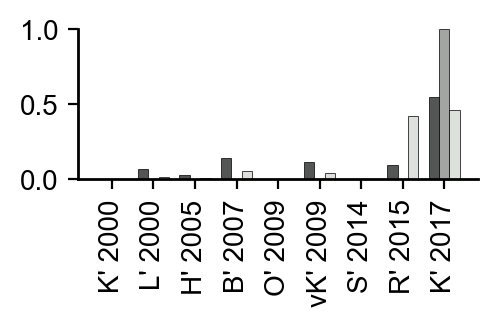

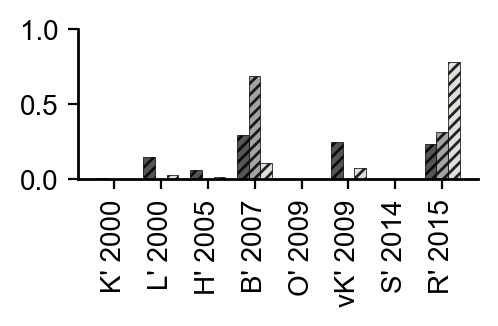

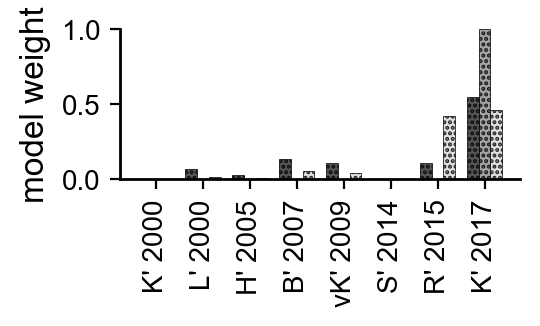

In [9]:
def make_weight_plot(pBMA, stack, model_probs, display_names, colors, filename=None,
                     ylabel='model weight', ax_width=2.5, ax_height=1., hatch=None):
    
    x = np.arange(len(display_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = get_sized_fig_ax(ax_width, ax_height)
    for dat, name, col in zip([pBMA, stack, model_probs], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
        offset = width * multiplier
        bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', hatch=hatch, alpha=0.85)
        # ax.bar_label(bar, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, display_names)
    leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(100.0, 1.0), ncols=2)
    if filename is not None:
        export_legend(leg, filename+'_leg.pdf')
    leg.remove()


    ax.set_ylabel(ylabel, fontsize=12.0)
    ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=10.0)
    ax.set_ylim([0, 1.0])

    if filename is not None:
        fig.savefig(filename+'.pdf', transparent=True)
    
    return fig, ax

# plots
make_weight_plot(pBMA_weight_all, stack_weight_all, model_probs_all, 
                 display_names_all, colors, 
                 filename='../../../results/MAPK/mmi/HF96_DR/model_weights_all', 
                 ylabel=None, ax_width=2., ax_height=0.75)
make_weight_plot(pBMA_weight_ExclGood, stack_weight_ExclGood, model_probs_ExclGood, 
                 display_names_ExclGood, colors, 
                 filename='../../../results/MAPK/mmi/HF96_DR/ExclGood_model_weights',
                 ylabel=None, ax_width=2., ax_height=0.75, hatch='//////')
make_weight_plot(pBMA_weight_ExclBad, stack_weight_ExclBad, model_probs_ExclBad, 
                 display_names_ExclBad, colors, 
                 filename='../../../results/MAPK/mmi/HF96_DR/ExclBad_model_weights',
                 ylabel='model weight', ax_width=2., ax_height=0.75, hatch='......')

## Generate and plot predictive samples from the averaged predictive density for the ExclGood and ExclBad cases

In [10]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='#5aae61', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

In [11]:
loo_pbma_combined_all = np.zeros_like(posterior_samples_all[0])
loo_stack_combined_all = np.zeros_like(posterior_samples_all[0])
loo_bma_combined_all = np.zeros_like(posterior_samples_all[0])
for i, name in enumerate(model_names_all):
    loo_pbma_combined_all += compare_data_loo_pbma_all.loc[name]['weight']*posterior_samples_all[i]
    loo_stack_combined_all += compare_data_loo_stack_all.loc[name]['weight']*posterior_samples_all[i]
    loo_bma_combined_all += model_probs_all[i]*posterior_samples_all[i]

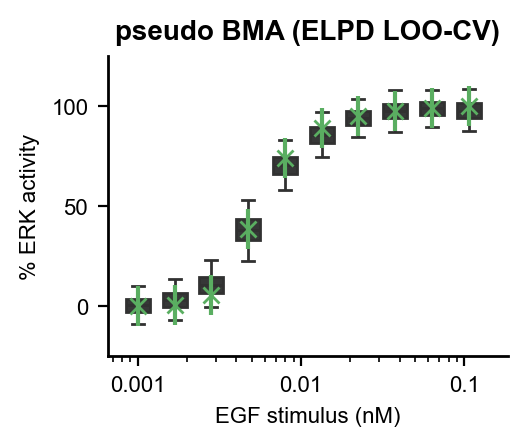

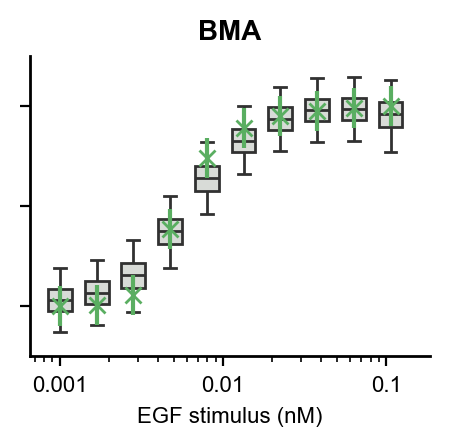

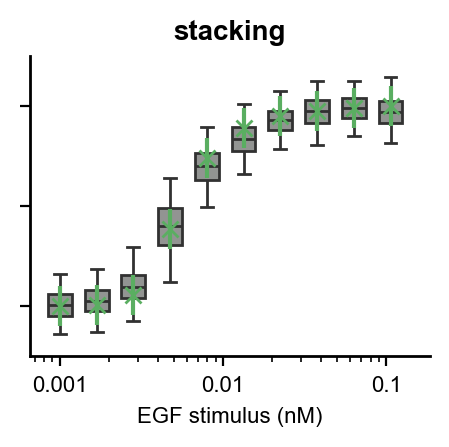

In [12]:
loo_pbma_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
loo_stack_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
loo_bma_combined_ExclGood = np.zeros_like(posterior_samples_ExclGood[0])
for i, name in enumerate(model_names_ExclGood):
    loo_pbma_combined_ExclGood += compare_data_loo_pbma_ExclGood.loc[name]['weight']*posterior_samples_ExclGood[i]
    loo_stack_combined_ExclGood += compare_data_loo_stack_ExclGood.loc[name]['weight']*posterior_samples_ExclGood[i]
    loo_bma_combined_ExclGood += model_probs_ExclGood[i]*posterior_samples_ExclGood[i]

fig, ax = plot_stimulus_response_curve(loo_pbma_combined_ExclGood, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10.0)
leg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclGood_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)

fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclGood_pbma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_bma_combined_ExclGood, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10.0)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclGood_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclGood_bma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_stack_combined_ExclGood, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10.0)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclGood_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclGood_stack_avg.pdf', transparent=True)

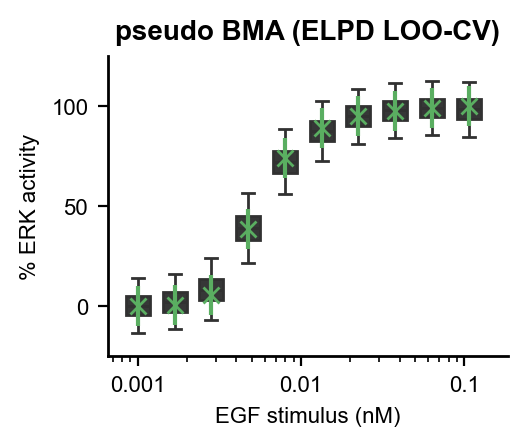

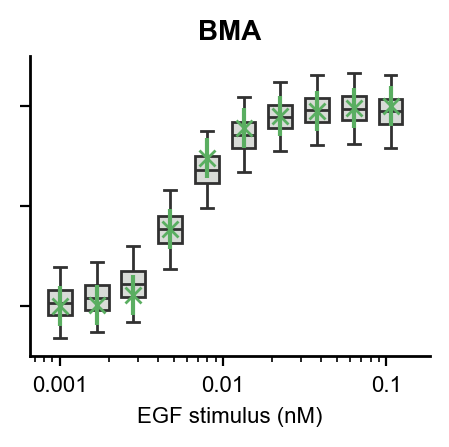

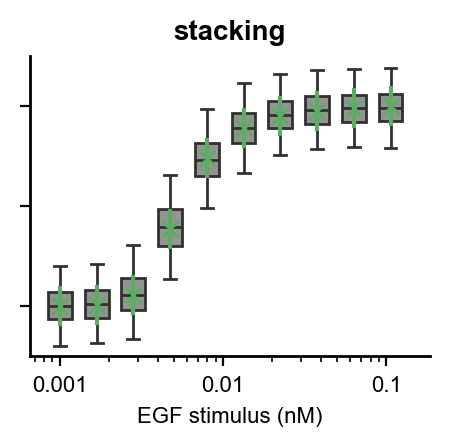

In [13]:
loo_pbma_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
loo_stack_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
loo_bma_combined_ExclBad = np.zeros_like(posterior_samples_ExclBad[0])
for i, name in enumerate(model_names_ExclBad):
    loo_pbma_combined_ExclBad += compare_data_loo_pbma_ExclBad.loc[name]['weight']*posterior_samples_ExclBad[i]
    loo_stack_combined_ExclBad += compare_data_loo_stack_ExclBad.loc[name]['weight']*posterior_samples_ExclBad[i]
    loo_bma_combined_ExclBad += model_probs_ExclBad[i]*posterior_samples_ExclBad[i]

fig, ax = plot_stimulus_response_curve(loo_pbma_combined_ExclBad, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10.0)
leg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclBad_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)

fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclBad_pbma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_bma_combined_ExclBad, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10.0)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclBad_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclBad_bma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_stack_combined_ExclBad, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2],
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10.0)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=8, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/ExclBad_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=8.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=8.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_DR/ExclBad_stack_avg.pdf', transparent=True)

## Compute RMSE for each set of MMI predictors

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)


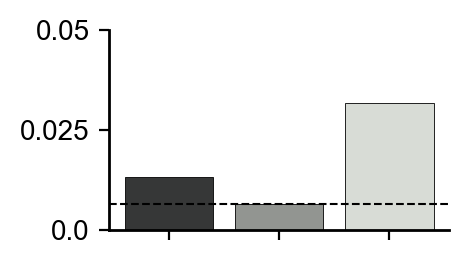

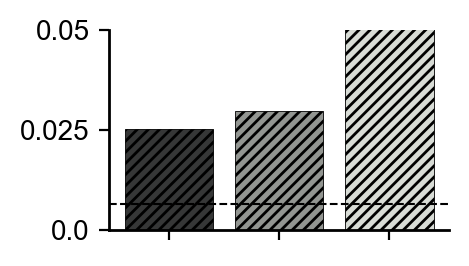

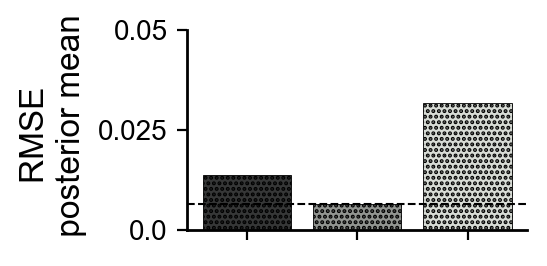

In [14]:
# Just models
RMSE_models_all = []
for i, name in enumerate(model_names_all):
    RMSE_models_all.append(np.sqrt(np.mean((np.mean(posterior_samples_all[i] - data.T, axis=0))**2)))

# MMI w/ all
RMSE_all = []

RMSE_all.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_stack_combined_all - data.T, axis=0))**2)))
RMSE_all.append(np.sqrt(np.mean((np.mean(loo_bma_combined_all - data.T, axis=0))**2)))

# MMI w/o best
RMSE_ExclGood = []

RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_ExclGood - data.T, axis=0))**2)))
RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_stack_combined_ExclGood - data.T, axis=0))**2)))
RMSE_ExclGood.append(np.sqrt(np.mean((np.mean(loo_bma_combined_ExclGood - data.T, axis=0))**2)))

# MMI w/o worst
RMSE_ExclBad = []

RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_pbma_combined_ExclBad - data.T, axis=0))**2)))
RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_stack_combined_ExclBad - data.T, axis=0))**2)))
RMSE_ExclBad.append(np.sqrt(np.mean((np.mean(loo_bma_combined_ExclBad - data.T, axis=0))**2)))


def make_bar_plot(quantity,xticklabels,colors,hatch,ylabel,yticks,yticklabels,
                  line_qoi=None, width=2.5, height=1.):

        fig, ax = get_sized_fig_ax(width, height)
        bar = ax.bar(xticklabels, quantity, edgecolor='k')
        for i, br in enumerate(bar):
                br.set_hatch(hatch)
                br.set_facecolor(colors[i])
        
        ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)
        ax.set_ylabel(ylabel, fontsize=12.0)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=10.0)
        ax.set_ylim([min(yticks), max(yticks)])

        if line_qoi is not None:
                xlim = ax.get_xlim()
                ax.plot(xlim, line_qoi*np.array([1.,1.]), 'k--', linewidth=0.75)
                ax.set_xlim(xlim)
        
        return fig, ax

# make a plot for all models
f0, a0 = make_bar_plot(RMSE_all,['pseudo-BMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],None,
                        None,[0.0, 0.025, 0.05], ['0.0', '0.025', '0.05'],
                        line_qoi=min(RMSE_models_all), width=1.7, height=1.)
a0.set_xticklabels('')

f0.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_RMSE.pdf', transparent=True)

# make a plot for ExclGood models
f1, a1 = make_bar_plot(RMSE_ExclGood,['pseudo-BMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],'//////',
                        None, [0.0, 0.025, 0.05], ['0.0', '0.025', '0.05'],
                        line_qoi=min(RMSE_models_all), width=1.7, height=1.)
a1.set_xticklabels('')
f1.savefig('../../../results/MAPK/mmi/HF96_DR/ExclGood_mmi_RMSE.pdf', transparent=True)

# make a plot for ExclBad models
f2, a2 = make_bar_plot(RMSE_ExclBad,['pseudo-BMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],'......',
                        'RMSE \n posterior mean', [0.0, 0.025, 0.05], ['0.0', '0.025', '0.05'],
                        line_qoi=min(RMSE_models_all), width=1.7, height=1.)
a2.set_xticklabels('')
f2.savefig('../../../results/MAPK/mmi/HF96_DR/ExclBad_mmi_RMSE.pdf', transparent=True)


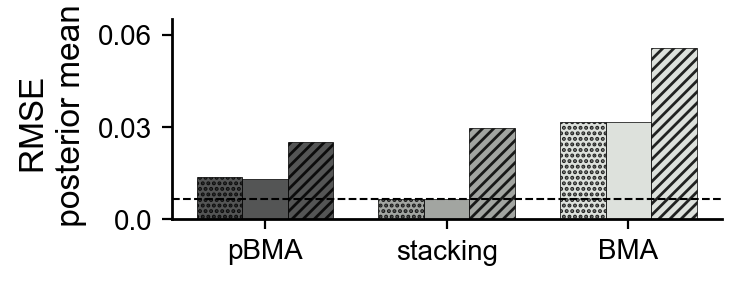

In [15]:
# grouped bar chart
def make_grouped_bar(quant_list, xticklabels, colors,  hatch, ylabel, yticks,yticklabels,
                  line_qoi=None, width=2.5, height=1., bar_width=0.25):
    
    x = np.arange(len(xticklabels))  # the label locations
    multiplier = 0

    fig, ax = get_sized_fig_ax(width, height)
    for i in range(len(quant_list)):
        offset = bar_width * multiplier
        bar = ax.bar(x + offset, quant_list[i], bar_width, edgecolor='k', hatch=hatch[i], alpha=0.85)
        for j, br in enumerate(bar):
            br.set_facecolor(colors[j])
        multiplier += 1

    ax.set_xticks(x + bar_width, xticklabels)
    ax.set_ylabel(ylabel, fontsize=12.0)
    ax.set_xticklabels(xticklabels, rotation=0, fontsize=10.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=10.0)
    ax.set_ylim([min(yticks), max(yticks)])

    if line_qoi is not None:
        xlim = ax.get_xlim()
        ax.plot(xlim, line_qoi*np.array([1.,1.]), 'k--', linewidth=0.75)
        ax.set_xlim(xlim)
    
    return fig, ax

f0, a0 = make_grouped_bar([RMSE_ExclBad, RMSE_all, RMSE_ExclGood], 
                          ['pBMA', 'stacking', 'BMA'], 
                          [colors[-3], colors[-2], colors[-1]],
                          ['......', None, '//////'], 'RMSE \n posterior mean', 
                          [0.0, 0.03, 0.06], ['0.0', '0.03', '0.06'],
                        line_qoi=min(RMSE_models_all), width=2.75, height=1.)
a0.set_ylim([0.0, 0.065])
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch='......', label='exclude worst model')
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch=None, label='all models')
a0.bar(np.nan, np.nan, color='w', edgecolor='k', hatch='//////', label='exclude best model')
leg = a0.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=1)
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR/mmi_RMSE_legend.pdf')
leg.remove()

f0.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_RMSE.pdf', transparent=True)

## Compute Posterior Uncertainty for all MMI preds

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_2895/2920894886.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10.0)


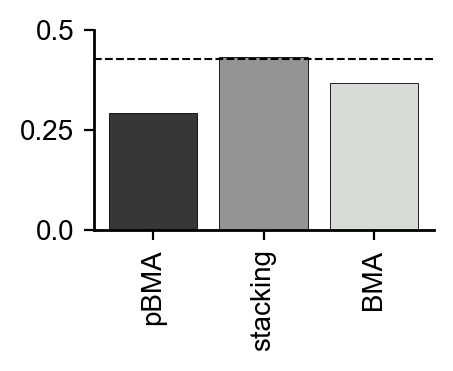

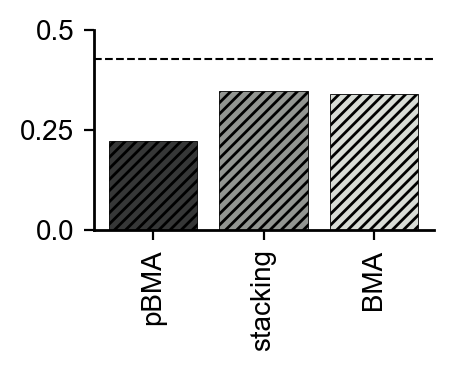

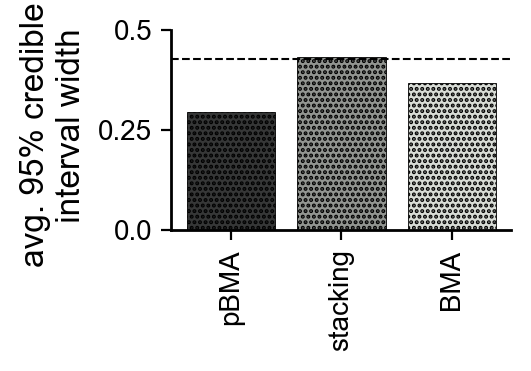

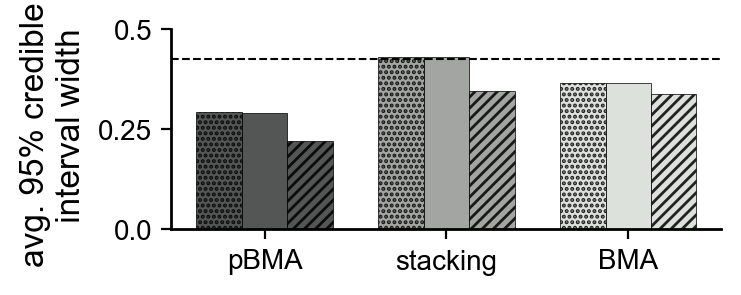

In [16]:

# Just models
uncert_95_models_all = []
for i, name in enumerate(model_names_all):
    uncert_95_models_all.append(np.mean(np.diff(np.quantile(posterior_samples_all[i], [0.025, 0.975], axis=0), axis=0)))

# MMI w/ all
uncert_95_all = []

uncert_95_all.append(np.mean(np.diff(np.quantile(loo_pbma_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_stack_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.mean(np.diff(np.quantile(loo_bma_combined_all, [0.025, 0.975], axis=0), axis=0)))

# MMI w/o best
uncert_95_ExclGood = []

uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_pbma_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_stack_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclGood.append(np.mean(np.diff(np.quantile(loo_bma_combined_ExclGood, [0.025, 0.975], axis=0), axis=0)))

# MMI w/o worst
uncert_95_ExclBad = []

uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_pbma_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_stack_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))
uncert_95_ExclBad.append(np.mean(np.diff(np.quantile(loo_bma_combined_ExclBad, [0.025, 0.975], axis=0), axis=0)))

# make a plot for all models
f0, a0 = make_bar_plot(uncert_95_all,['pBMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],None,
                        None,[0.0, 0.25, 0.5], ['0.0', '0.25', '0.5'],
                        line_qoi=min(uncert_95_models_all), width=1.7, height=1.)

f0.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_uncert_95.pdf', transparent=True)

# make a plot for ExclGood models
f1, a1 = make_bar_plot(uncert_95_ExclGood,['pBMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],'//////',
                        None, [0.0, 0.25, 0.5], ['0.0', '0.25', '0.5'],
                        line_qoi=min(uncert_95_models_all), width=1.7, height=1.)

f1.savefig('../../../results/MAPK/mmi/HF96_DR/ExclGood_mmi_uncert_95.pdf', transparent=True)

# make a plot for ExclBad models
f2, a2 = make_bar_plot(uncert_95_ExclBad,['pBMA', 'stacking', 'BMA'],
                       [colors[-3], colors[-2], colors[-1]],'......',
                        'avg. 95% credible \n interval width', [0.0, 0.25, 0.5], ['0.0', '0.25', '0.5'],
                        line_qoi=min(uncert_95_models_all), width=1.7, height=1.)

f2.savefig('../../../results/MAPK/mmi/HF96_DR/ExclBad_mmi_uncert_95.pdf', transparent=True)


f3, a3 = make_grouped_bar([uncert_95_ExclBad, uncert_95_all, uncert_95_ExclGood], 
                          ['pBMA', 'stacking', 'BMA'], 
                          [colors[-3], colors[-2], colors[-1]],
                          ['......', None, '//////'], 'avg. 95% credible \n interval width',
                          [0.0, 0.25, 0.5], ['0.0', '0.25', '0.5'],
                        line_qoi=min(uncert_95_models_all), width=2.75, height=1.)

f3.savefig('../../../results/MAPK/mmi/HF96_DR/mmi_uncert_95.pdf', transparent=True)